# Operating Systems Report - 231006

## Experiment 1 - Comparing the average wait time for each algorithm

### Introduction
In this experiment, I look to find out which scheduling algorithm is best used when it comes to minimizing the average waiting time. I hypothesise that the best scheduling algorithm for minimising wait time is the Multilevel Feed Back Queue with Round Robin, which, is the pre-emptive and when using a time quantum, is able to context switch from longer processes when they exceed the time quantum. I expect that shortest job first with exponential averaging will perform poorly compared to the other scheduling algorithms owing to the fact that it is non-preemptive.

### Methodology
In order to test which algorithm has the best average waiting time, I will run the experiment (and all subsequent experiments) using the `run.sh` script. This will run the experiment for each scheduling, for each scheduling algorithm, we will choose 5 different seeds so that we can get a stable average waiting time. Inputs generated by the bash script are stored in `/experiment1/inputs` and the simulator parameters used are stored in `/experiment1/sim_params/`. Outputs are stored in `/experiment1/schedulers/[scheduler]` The only variation in the parameters is the scheduling algorithm used. I will calculate the average waiting time across all 5 seeds for each scheduling algorithm and then compare the average waiting times for each scheduling algorithm, this way I can see which algorithm has the best average waiting time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from experiment import Experiment

exp = Experiment('./experiment1')

print("Seeds Used: ")
print("Input Params of experiment with seed " + exp.get_input(1)[0])

exp.input_params[1].head()


Seeds Used: 
Input Params of experiment with seed 120


,value
param,
numberOfProcesses,50
staticPriority,0
meanInterArrival,12
meanCpuBurst,10
meanIoBurst,10


In [2]:
print("Simulation params of experiment: (note scheduler is missing as it will be changing)")
exp.sim_params[0].drop(['scheduler'])

Simulation params of experiment: (note scheduler is missing as it will be changing)


,value
param,
timeLimit,10000
interruptTime,1
timeQuantum,5
initialBurstEstimate,5
alphaBurstEstimate,0.5
periodic,false


As can be seen above, we use an interrupt time of `1 unit` and a time quantum of `5 units`. I chose these values so ensure that the processes that use RoundRobin (RR) and Feedback Round Robin (FRR) are forced to make a context switch so that they cannot always run for the entire time quantum. I chose the ratio 1:5 to reduce too much overhead in the system to try and get a fair comparison.

### Results


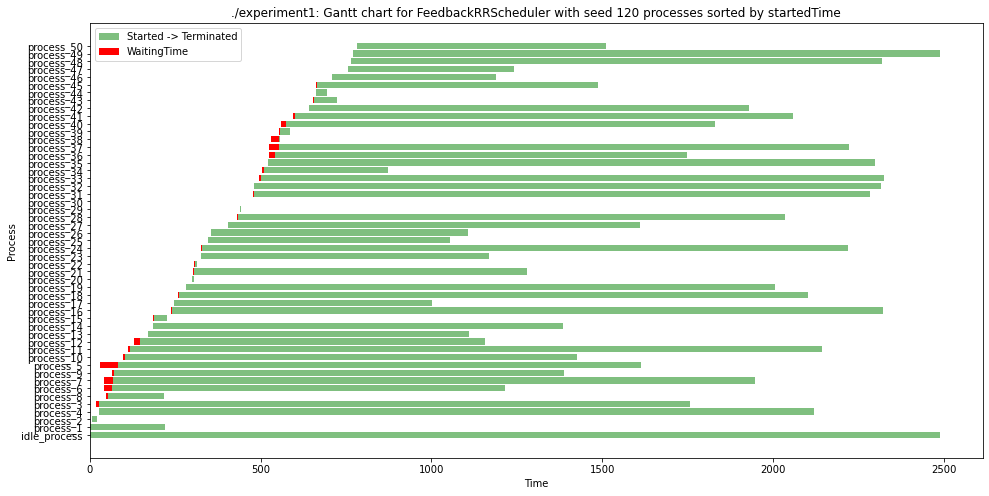

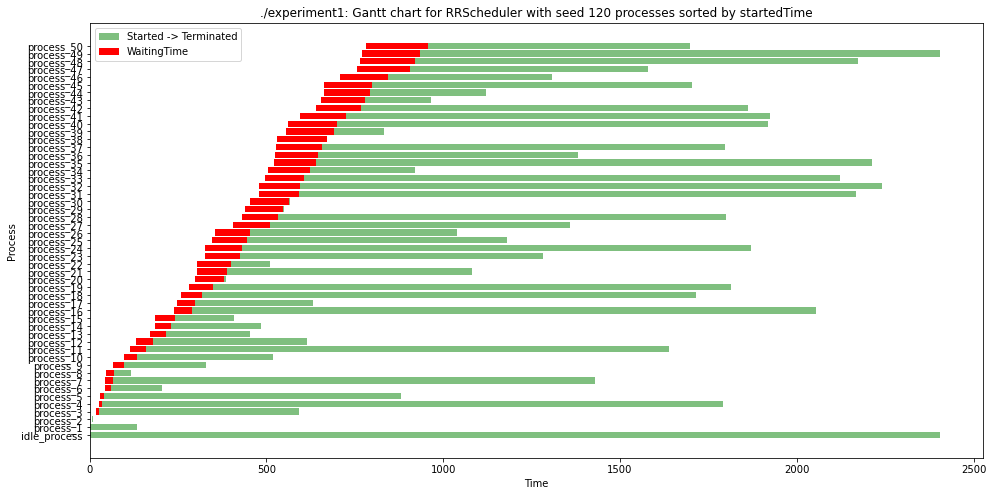

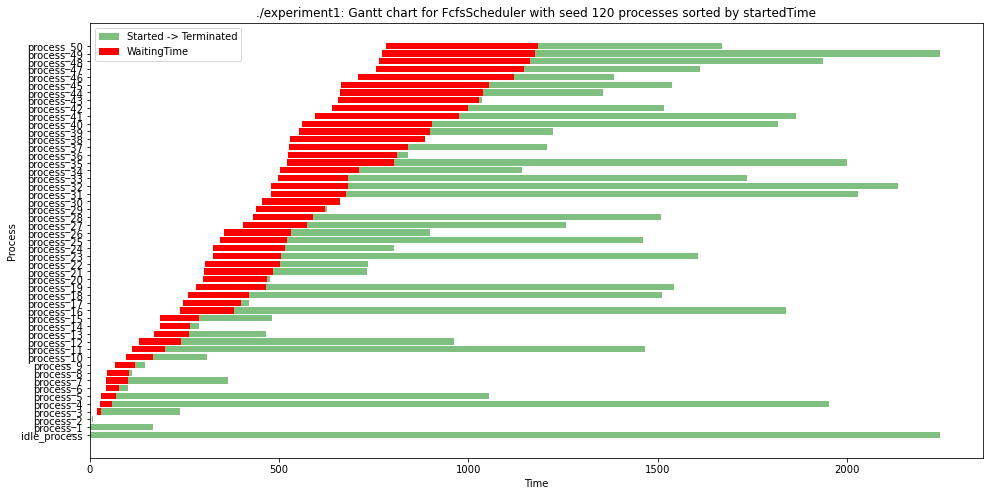

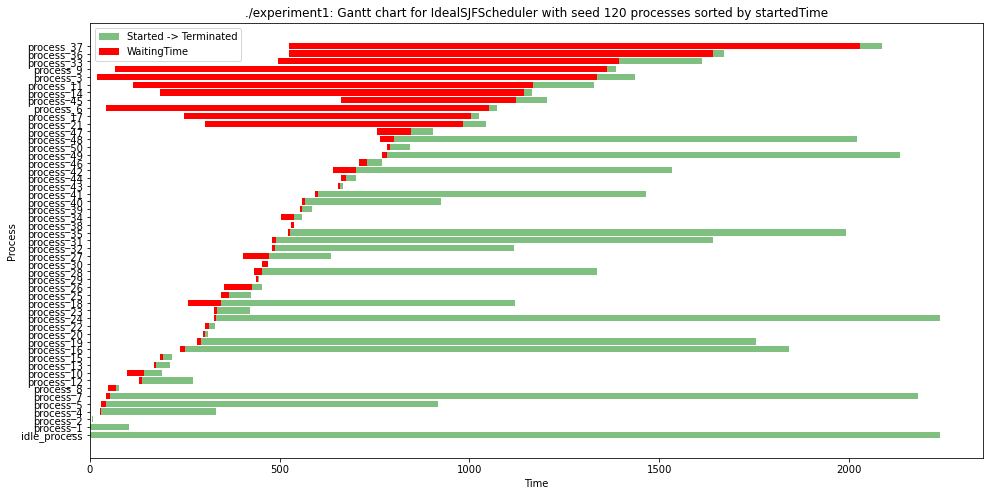

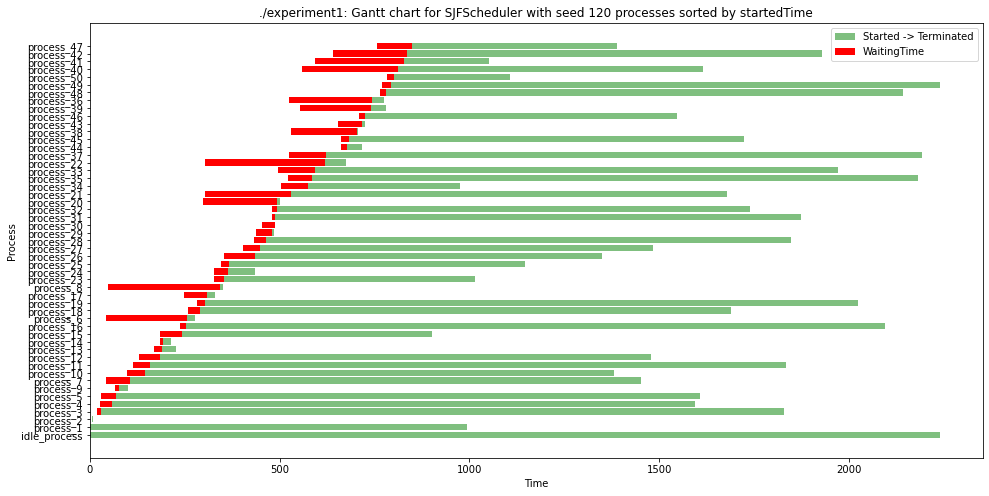

In [3]:
## Plotting and Comparing Gantt Charts for Different Schedulers 
exp.plot_gantt('FeedbackRRScheduler', '120')
exp.plot_gantt('RRScheduler', '120')
exp.plot_gantt('FcfsScheduler', '120')
exp.plot_gantt('IdealSJFScheduler', '120')
exp.plot_gantt('SJFScheduler', '120')

As can clearly be seen from the above example, the wait time on the Feedback Round Robin (FRR) algorithm is the lowest, followed by the Round Robin Algorithm algorithm. To validate this result, I will look across multiple different seeds and analyse the average waiting time for each scheduling algorithm.

In [4]:
meanWaitingTimes = exp.get_output_col('waitingTime').mean()
meanWaitingTimes

newCols = set(meanWaitingTimes.index.map(lambda x: x.split('_')[0]))
stats = pd.DataFrame(index=newCols, columns=["MeanWaitingTime"])

# Calculating the means for each scheduler
for scheduler in newCols:
	matching = [col for col in meanWaitingTimes.index if scheduler in col]
	meanOfScheduler = meanWaitingTimes[matching].mean()

	stats['MeanWaitingTime'][scheduler] = meanOfScheduler
stats


,MeanWaitingTime
FeedbackRRScheduler,17.062745
IdealSJFScheduler,281.54902
RRScheduler,60.166667
FcfsScheduler,244.913725
SJFScheduler,228.266667


Text(0, 0.5, 'Scheduler')

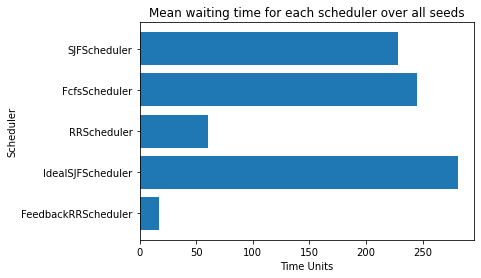

In [5]:
plt.barh(stats.index, stats['MeanWaitingTime'])
plt.title("Mean waiting time for each scheduler over all seeds")

plt.xlabel("Time Units")
plt.ylabel("Scheduler")

As can be seen above, the `FeedbackRRScheduler` algorithm which uses round robin and a multi-level queue that demotes the process and returns it to the back of the queue when it has reached its time quantum has the best average waiting time when given the same input as the other algorithms, this is followed by the Round Robin algorithm. This shows a multi-level feedback queue with the Round Robin algorithm as the best algorithm for minimising average waiting time.

It is important to note that we must take into account the fact that the time quantum and small interrupt time is key to ensuring that a multi-level feedback queue with this approach outperforms the Ideal Shortest Job First algorithm. In cases where the time quantum is higher than the interrupt time, the multi-level feedback queue will outperform or match the Ideal Shortest Job First algorithm.

I am interested by the impact of the time quantum and interrupt time on the average waiting time for each scheduling algorithm and how the keen to look into how performance of Ideal Shortest Job First and the multi-level feedback queue compare.

It can also be noted that the waiting time for both the First Come First Serve and Shortest Job First algorithms is extremely long compared to other algorithms, this is likely down to the emerging of the convoy effect, where larger processes are forced to wait for smaller processes to finish. I am interested to see whether the non-preemptive Shortest Job First algorithm can have its input parameters tuned to perform better under this type of scenario.

## Experiment 2 - Which scheduling algorithm is most effective for maximizing CPU utilization whilst minimizing average turnaround time?

### Introduction

I am interested it finding out what scheduling algorithm is most effective for maximizing CPU utilization whilst minimizing average turnaround time. 

In [6]:
exp = Experiment('./experiment2')
exp

### Methodology
To analyse how different algorithms perform, I use the following parameters:

#### Input Parameters
```
numProcesses=25
interArrivalTime=10
meanIoBurstTime=24
meanCpuBurstTime=4
meanNumBursts=10
```

The mean IO burst time I have chosen to be substantially higher than the mean CPU burst time, this is to ensure that the workload is high and varied so that the convoy effect is more likely to occur. 

#### Simulator Parameters
```
timeLimit=5000
interruptTime=10
timeQuantum=4
initialBurstEstimate=14
alphaBurstEstimate=0.5
periodic=false
```

I have initially chosen these values to try and give the exponential averaging algorithm a good chance initially, will an initial burst time of `14` and an alpha burst time of `0.5`.

In [7]:
shortest_job_first_output = [o[1] for o in exp.get_output('SJFScheduler')]

print("Example of shortest job first output:")
shortest_job_first_output[3]

Example of shortest job first output:


,id,priority,createdTime,startedTime,terminatedTime,cpuTime,blockedTime,turnaroundTime,waitingTime,responseTime
process_1,1,0,0,10,221,105,2,221,12,10
process_2,2,0,9,31,440,183,6,431,28,22
process_25,25,0,389,476,498,22,0,109,87,87
process_7,7,0,80,253,515,62,10,435,183,173
process_6,6,0,74,463,581,12,2,507,391,389
process_10,10,0,145,673,986,106,6,841,534,528
process_24,24,0,359,591,1098,90,12,739,244,232
process_21,21,0,334,612,1175,115,14,841,292,278
process_20,20,0,326,1212,1277,33,1,951,887,886
process_19,19,0,313,1131,1391,40,5,1078,823,818


I will first examine the Gantt Charts for each scheduling algorithm with these parameters. To calculate CPU utilization, I intend to use the following formula (as defined in `experiment.py`):

```
CPU utilization = 100 - (total_cpuTime - total_idleTime / total_time)
```

In [8]:
results = pd.DataFrame(columns=["Seed", "Algorithm", "MeanWaitingTime", "MeanTurnaroundTime", "CpuUtilization"])

### Results for Seed 15167

CPU Utilization for FeedbackRRScheduler: 98.99%
CPU Utilization for RRScheduler: 98.988%
CPU Utilization for FcfsScheduler: 98.989%
CPU Utilization for IdealSJFScheduler: 98.985%
CPU Utilization for SJFScheduler: 98.997%


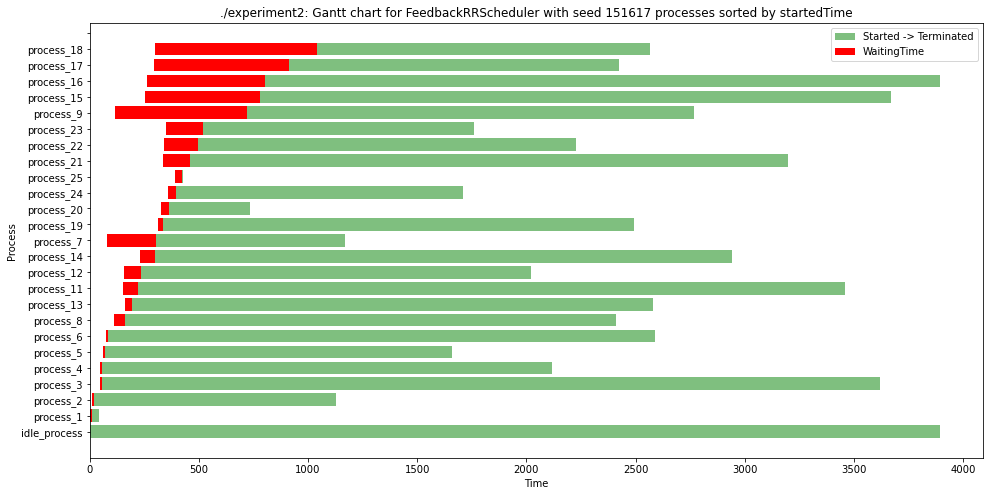

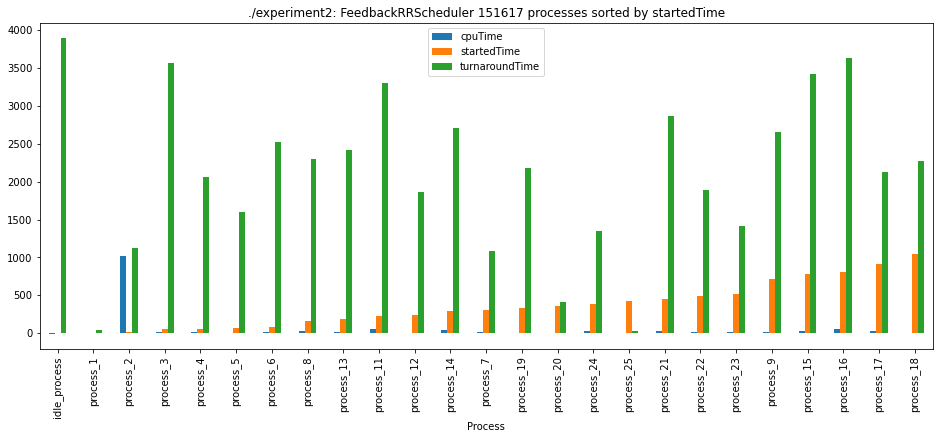

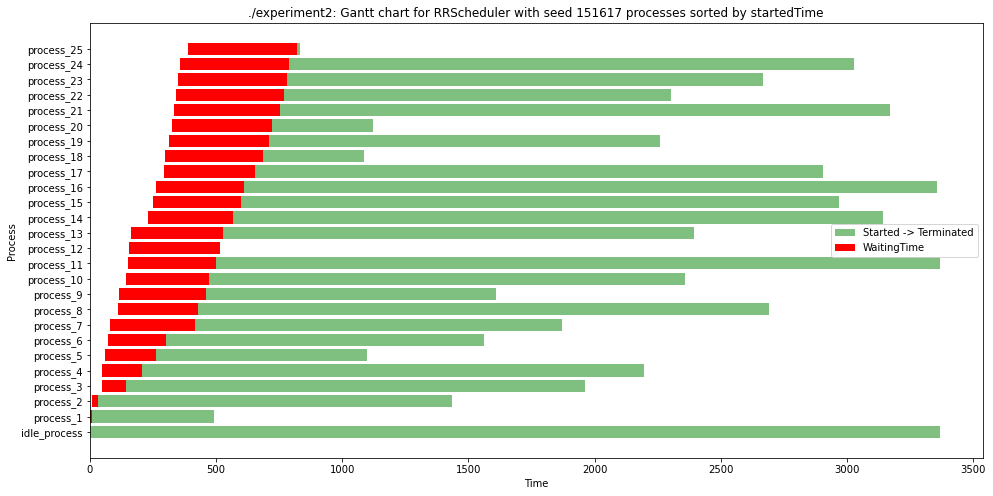

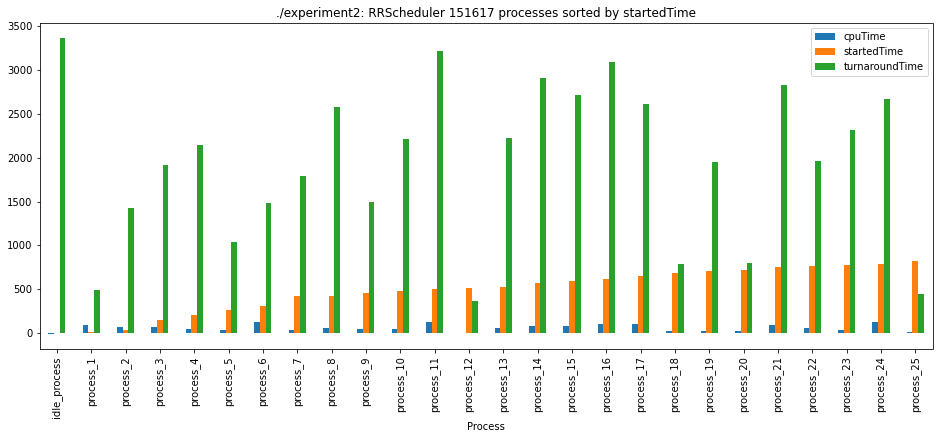

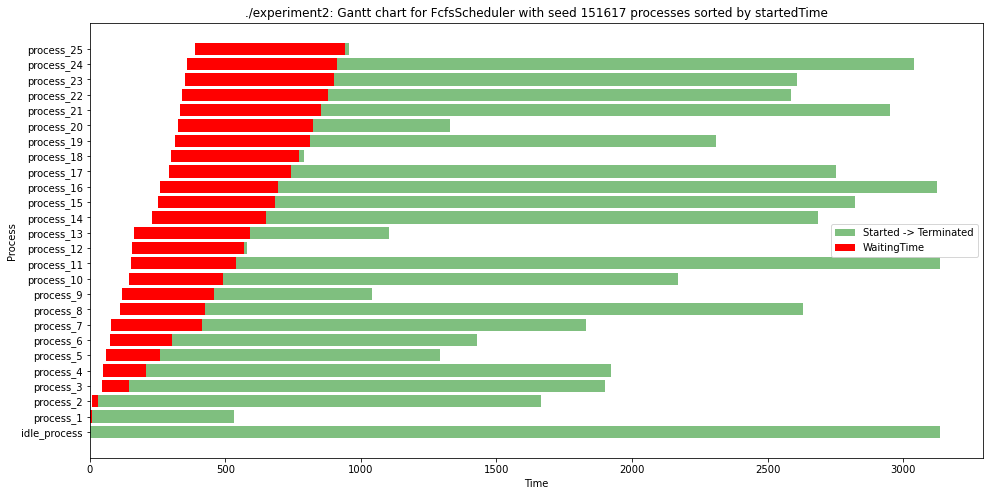

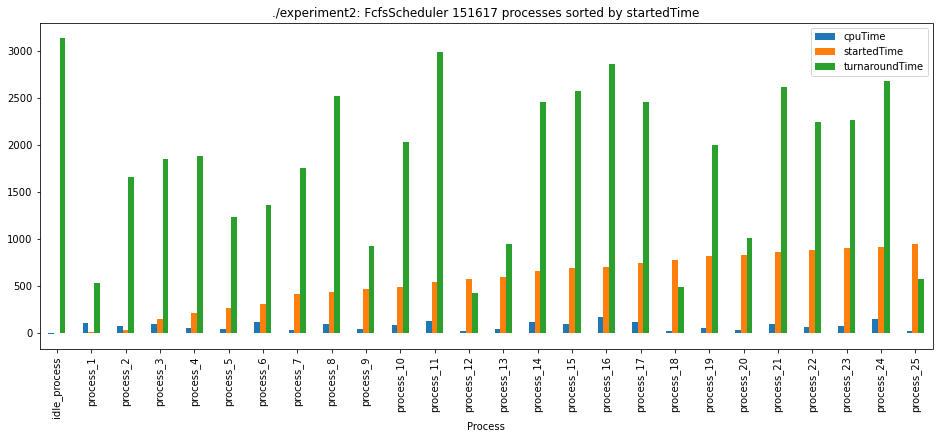

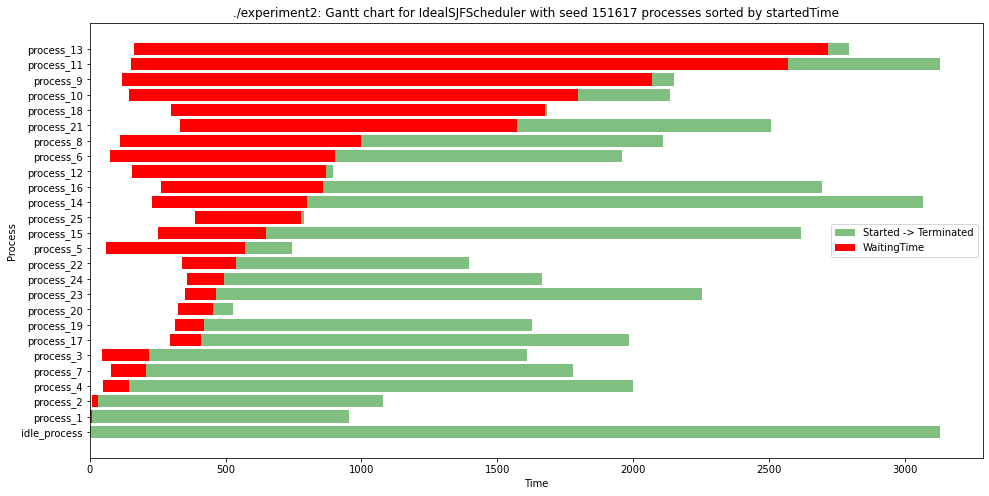

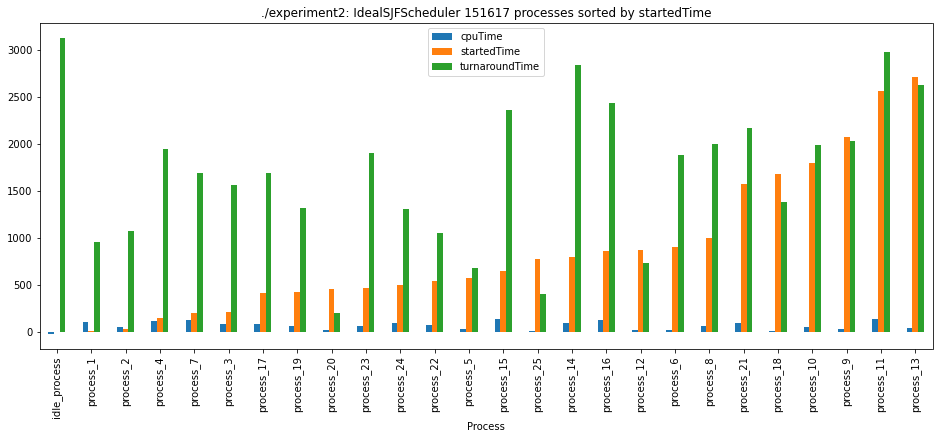

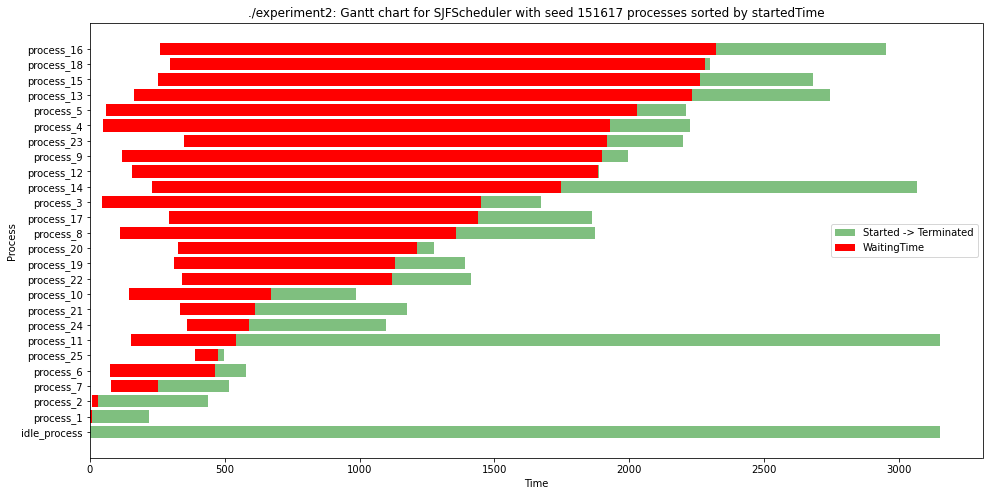

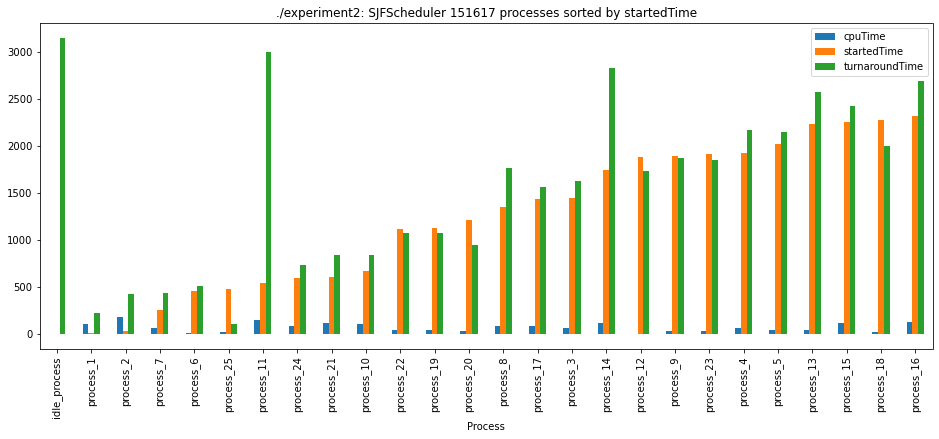

In [9]:
seed_to_analyse = "151617"
schedulers = ['FeedbackRRScheduler', 'RRScheduler', 'FcfsScheduler', 'IdealSJFScheduler', 'SJFScheduler']

def show_results(exp, scheduler, seed_to_analyse):
	exp.plot_gantt(scheduler, seed_to_analyse)
	exp.plot_cols_for_output(scheduler, seed_to_analyse)
	util = exp.calculate_cpu_utilization_for_output(scheduler, seed_to_analyse)
	results.loc[len(results)] = [seed_to_analyse, scheduler, exp.get_output_for_seed(scheduler, seed_to_analyse).waitingTime.mean(), exp.get_output_for_seed(scheduler, seed_to_analyse).terminatedTime.mean() - exp.get_output_for_seed(scheduler, seed_to_analyse).startedTime.mean(), util]
	
	print(f"CPU Utilization for {scheduler}: {util.round(3)}%")
	
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)




### Results for Seed 91011

CPU Utilization for FeedbackRRScheduler: 98.985%
CPU Utilization for RRScheduler: 98.995%
CPU Utilization for FcfsScheduler: 98.991%
CPU Utilization for IdealSJFScheduler: 98.995%
CPU Utilization for SJFScheduler: 98.995%


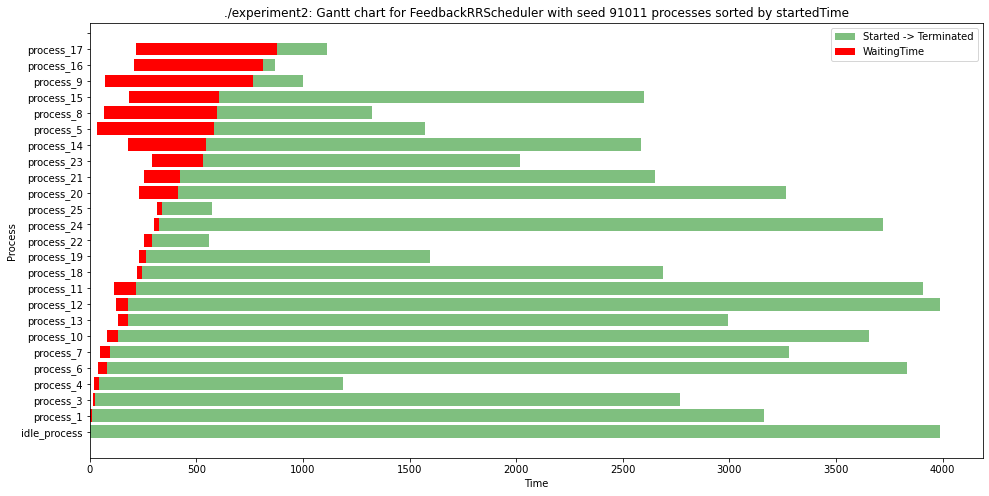

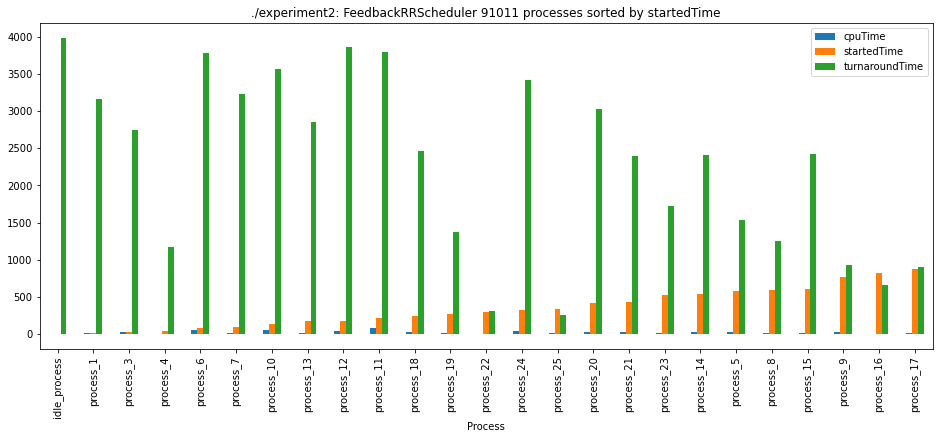

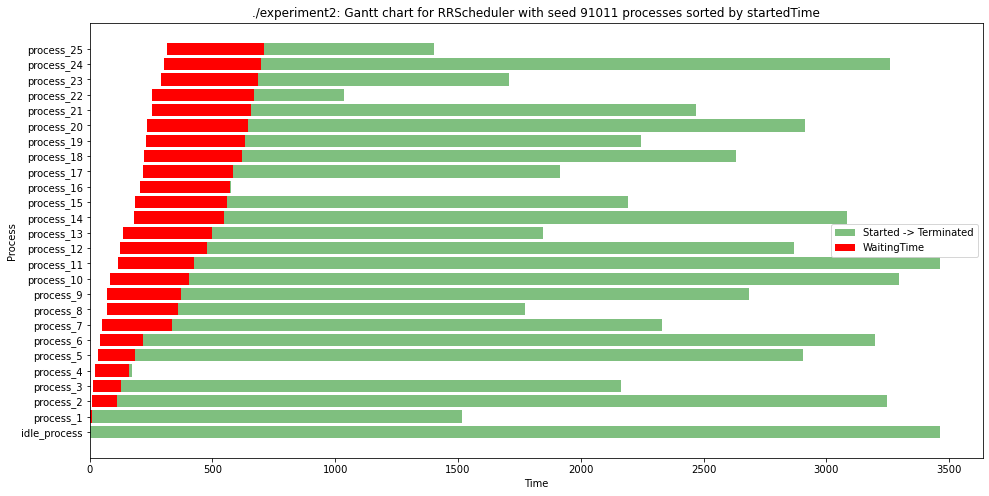

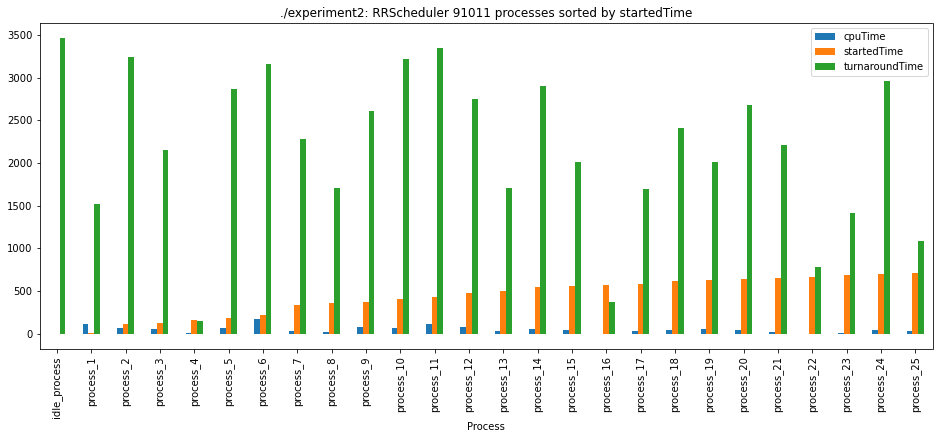

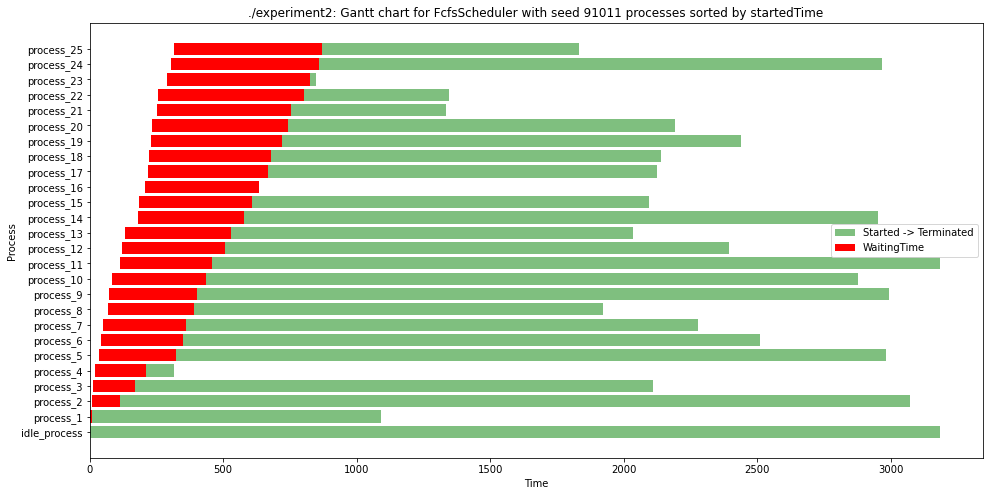

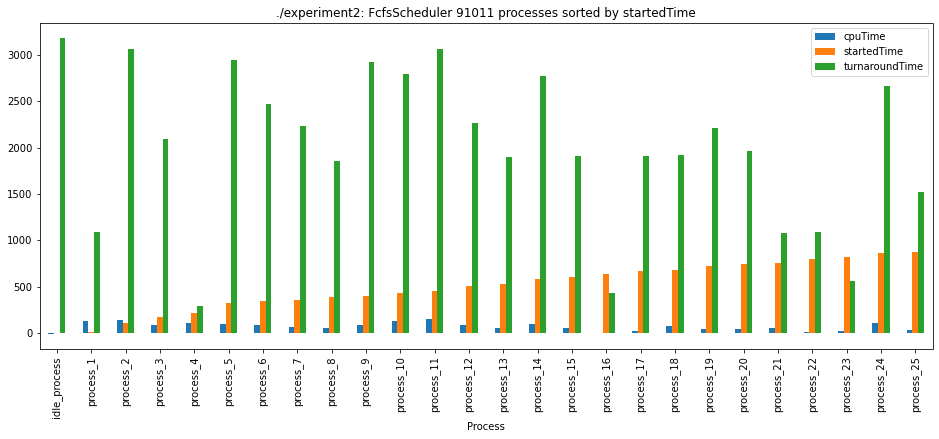

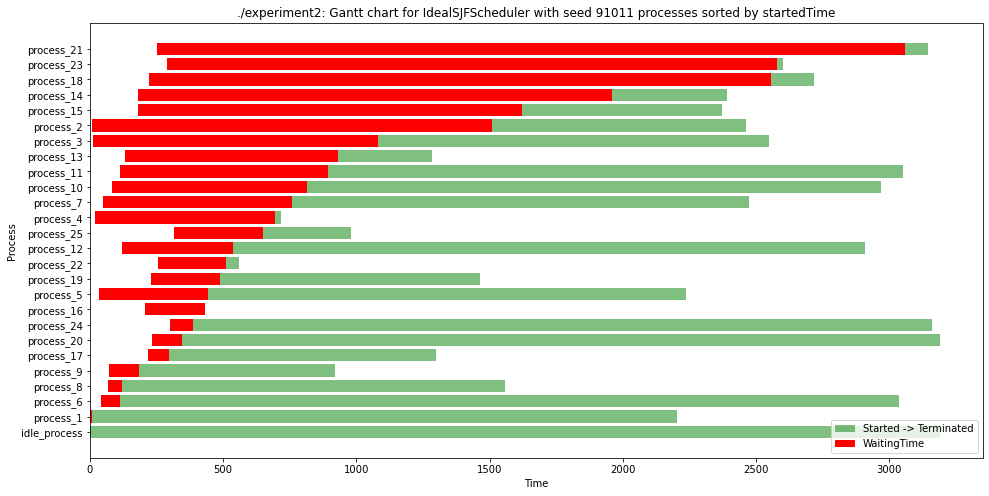

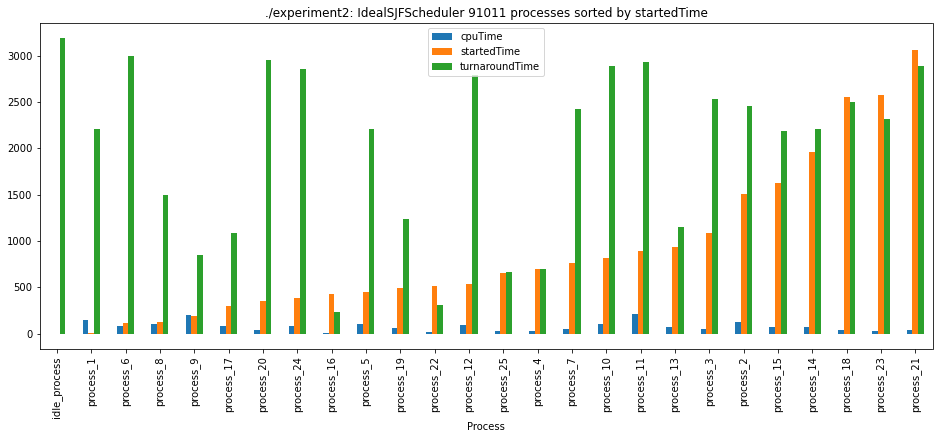

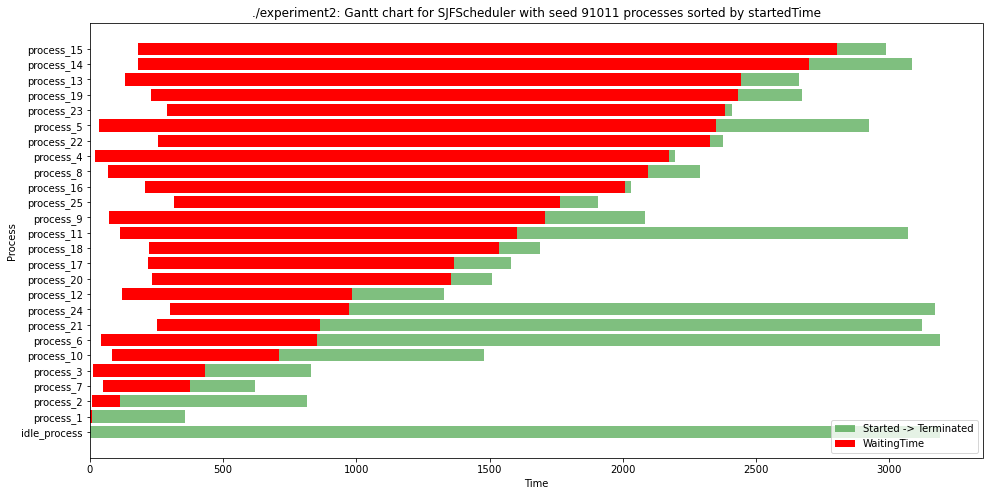

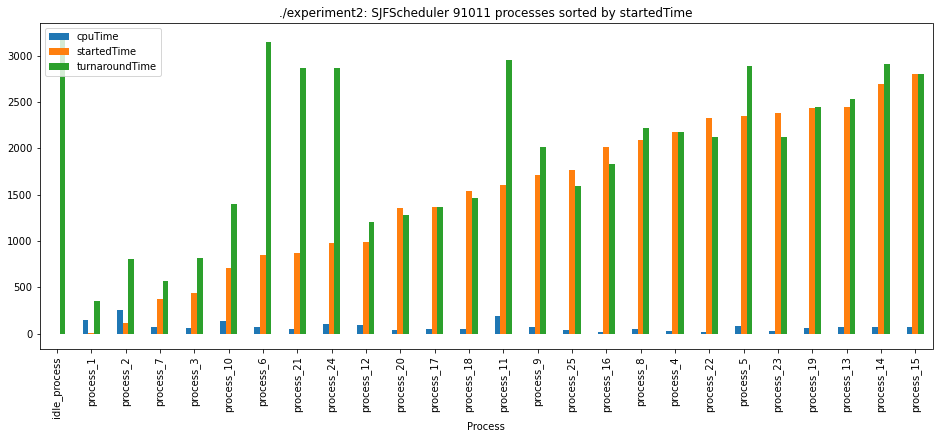

In [10]:
seed_to_analyse = '91011'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 151617

CPU Utilization for FeedbackRRScheduler: 98.99%
CPU Utilization for RRScheduler: 98.988%
CPU Utilization for FcfsScheduler: 98.989%
CPU Utilization for IdealSJFScheduler: 98.985%
CPU Utilization for SJFScheduler: 98.997%


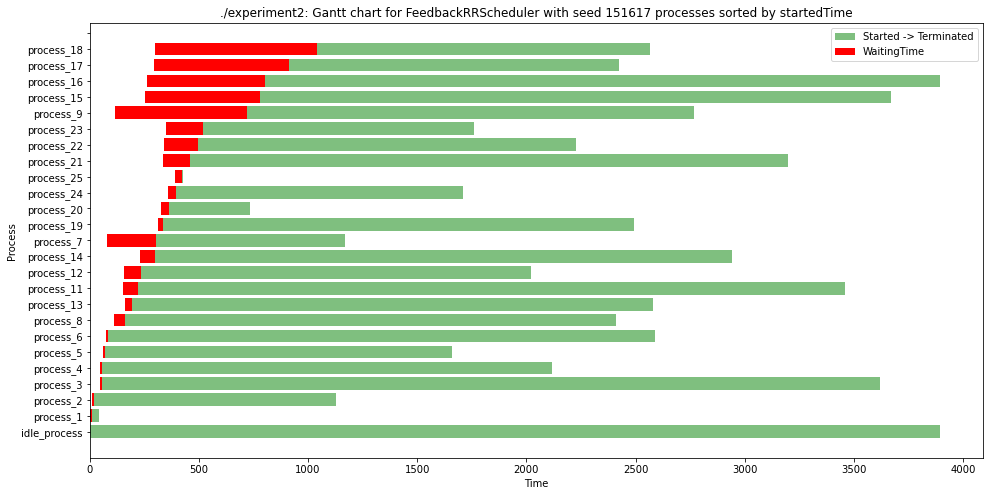

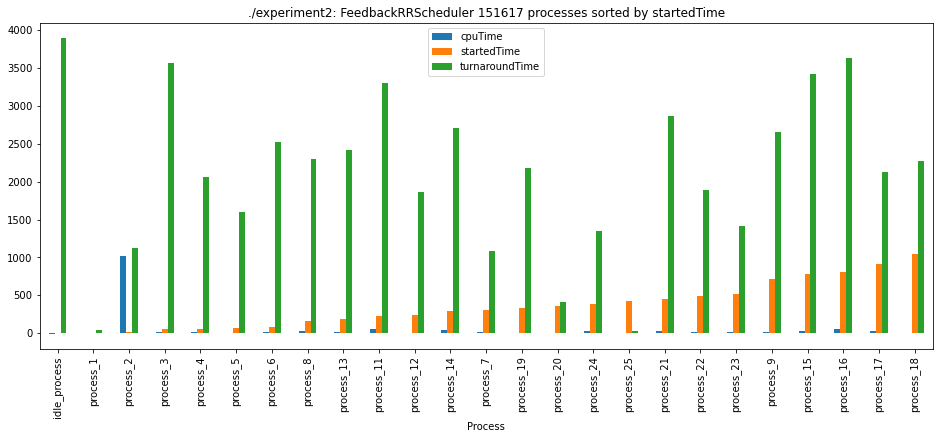

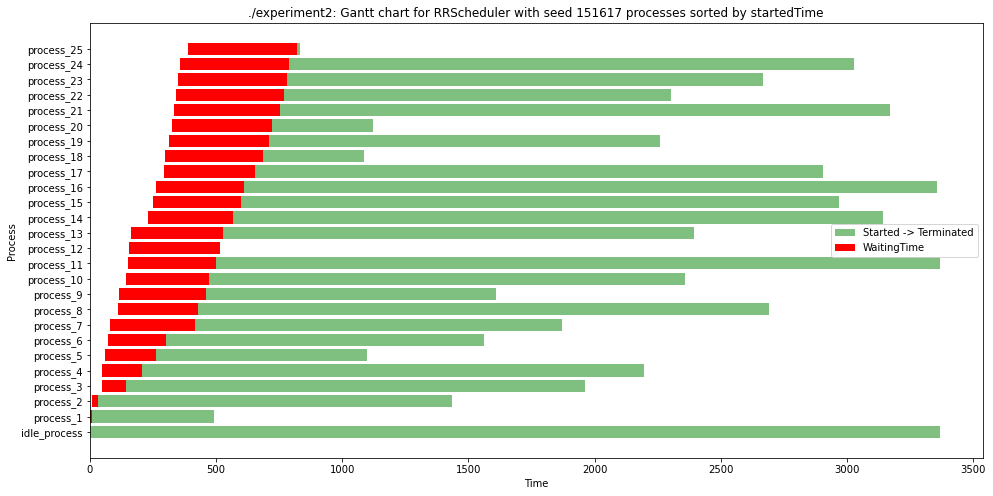

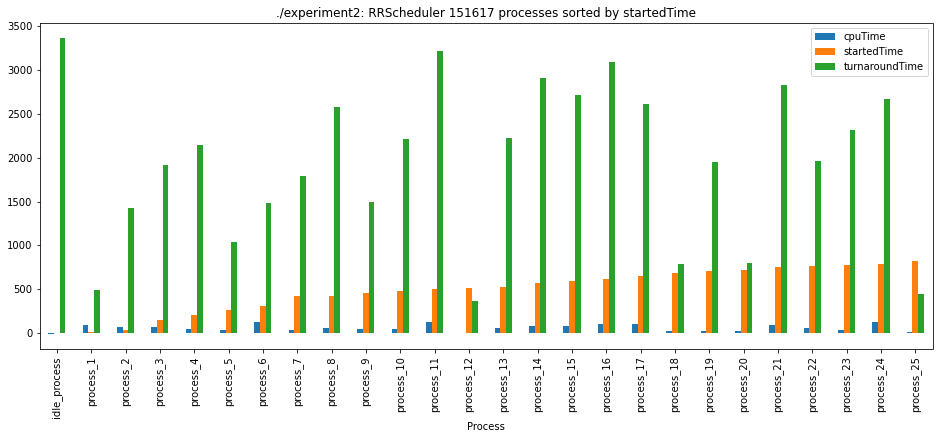

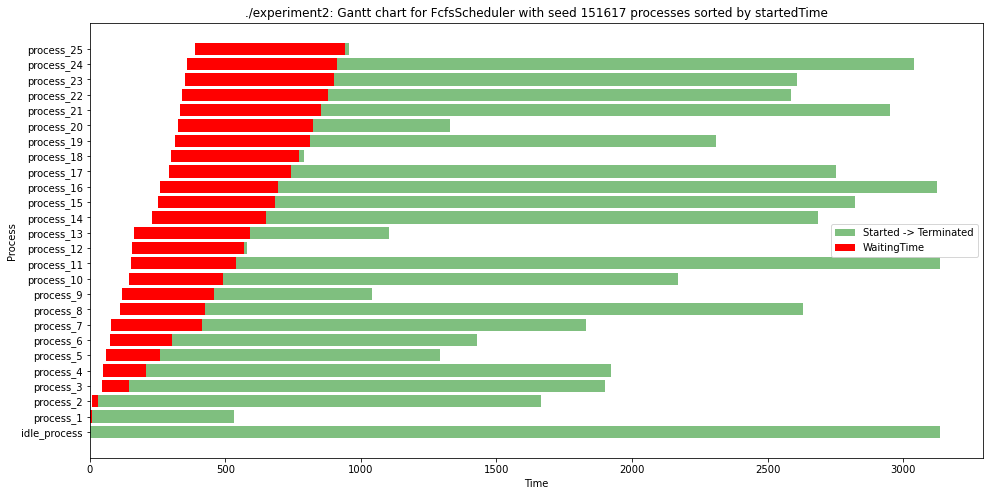

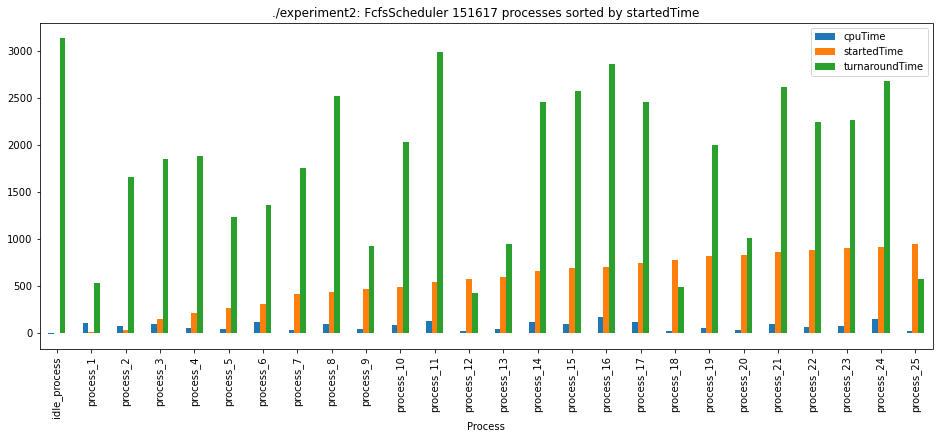

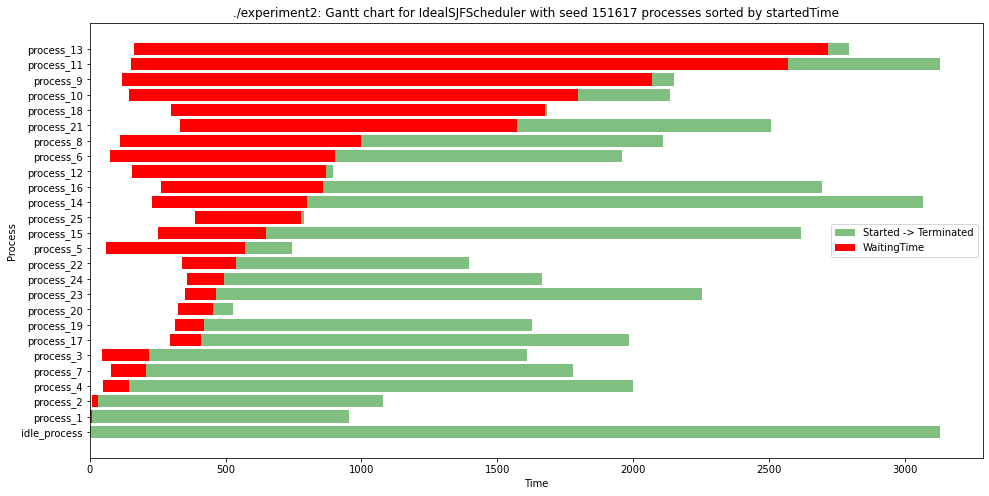

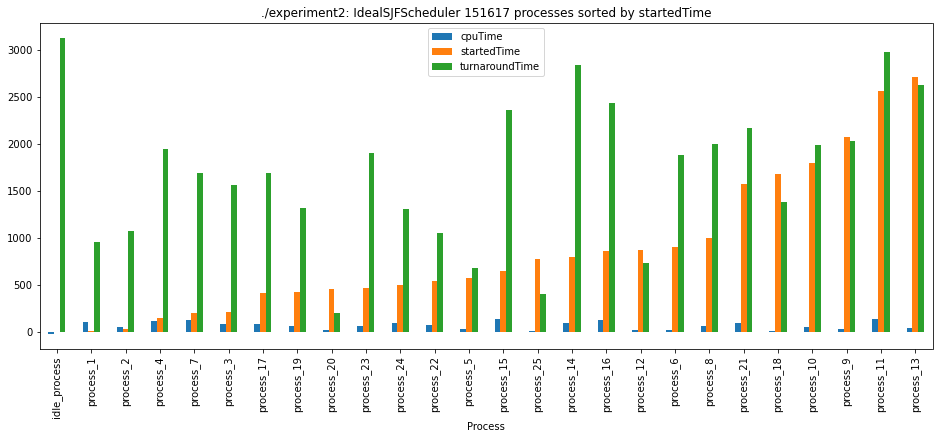

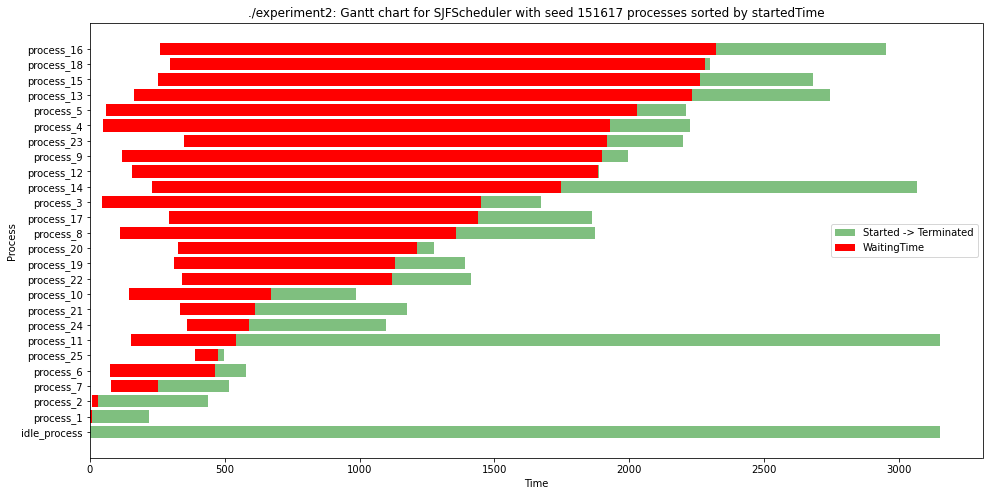

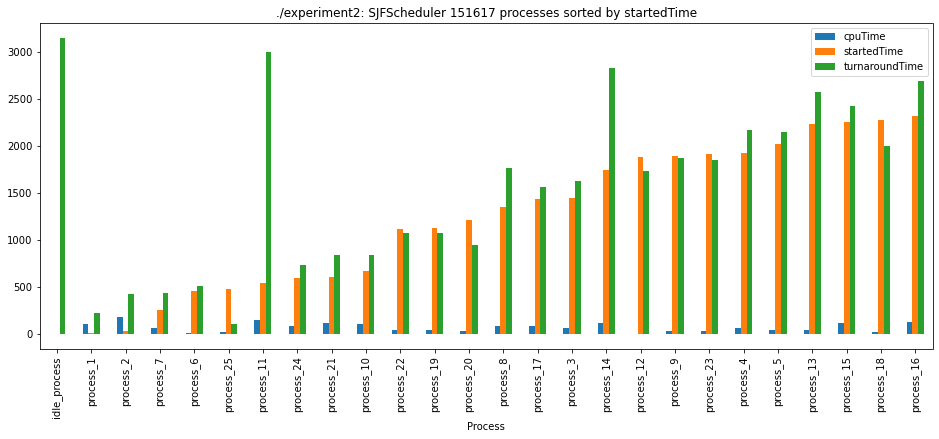

In [11]:
seed_to_analyse = '151617'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 121314

CPU Utilization for FeedbackRRScheduler: 99.219%
CPU Utilization for RRScheduler: 98.987%
CPU Utilization for FcfsScheduler: 98.985%
CPU Utilization for IdealSJFScheduler: 98.993%
CPU Utilization for SJFScheduler: 98.999%


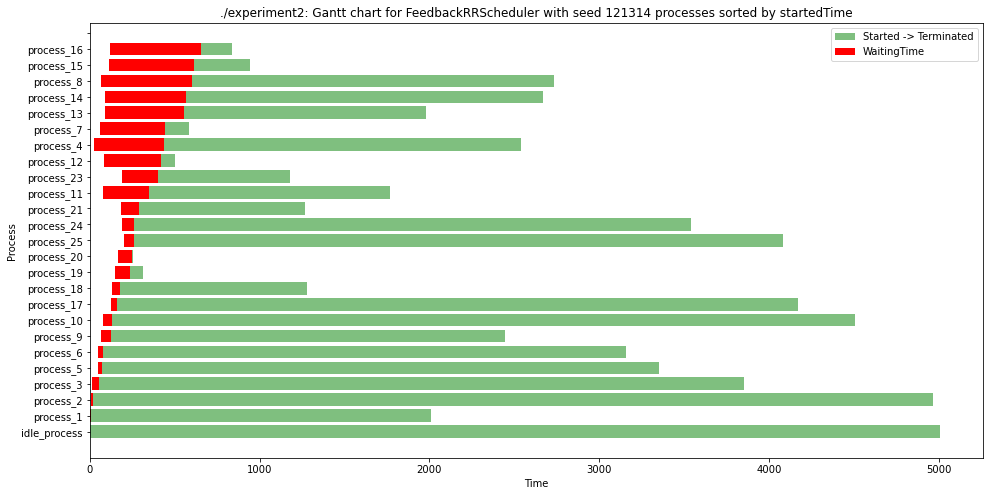

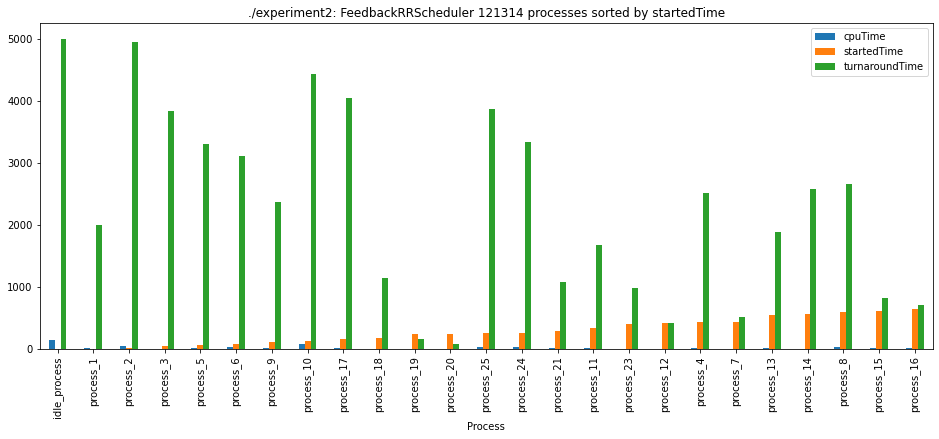

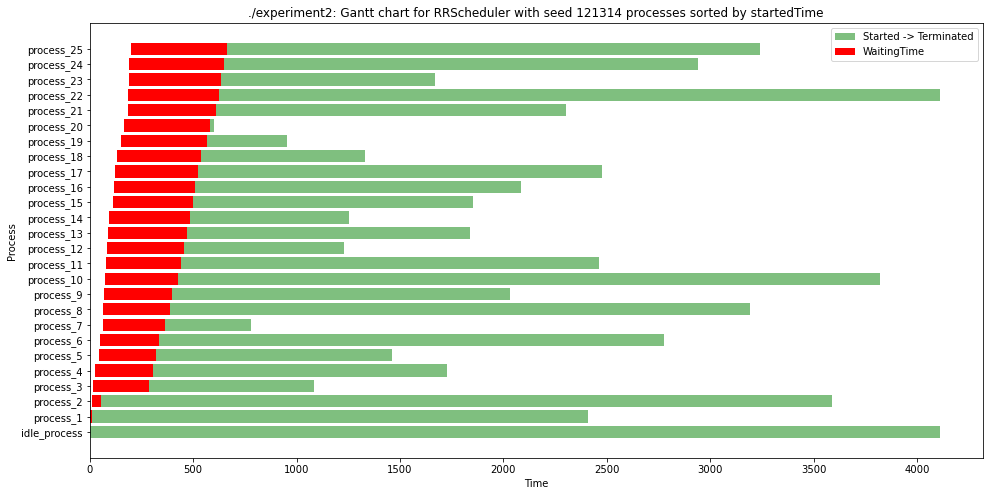

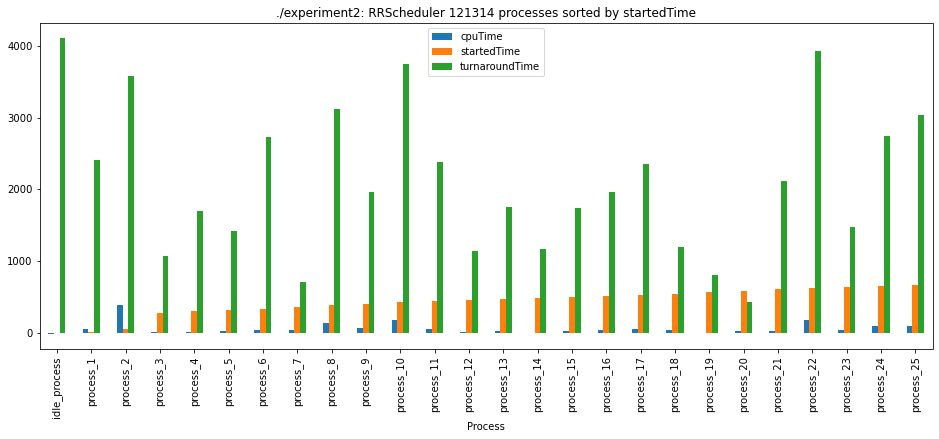

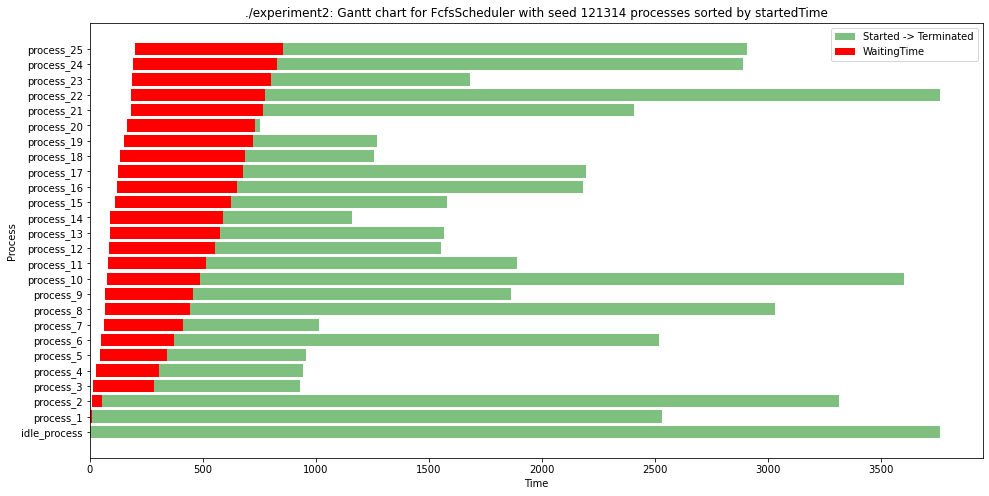

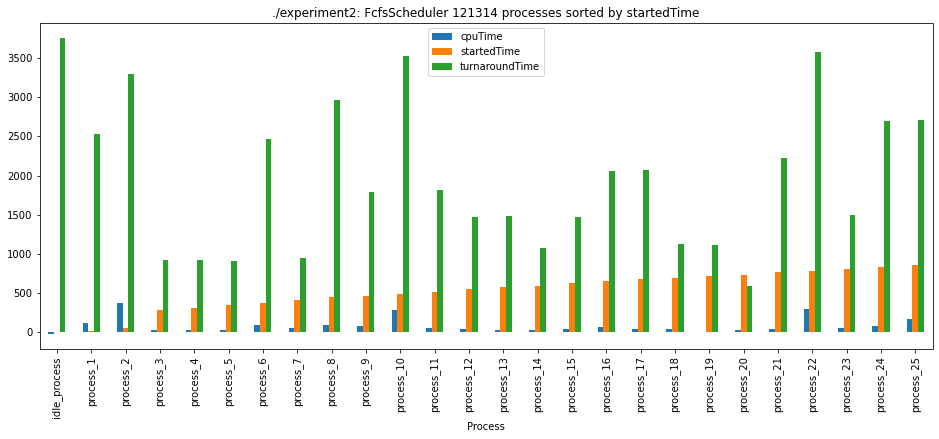

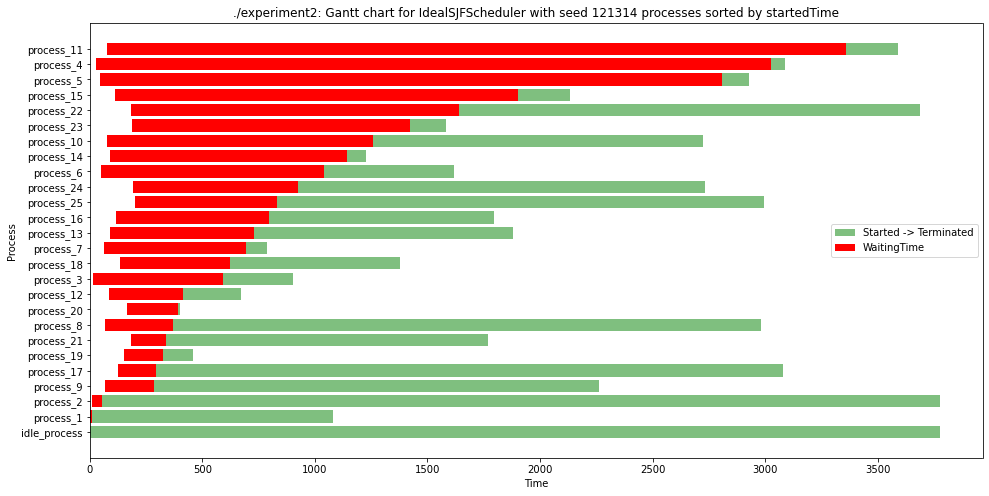

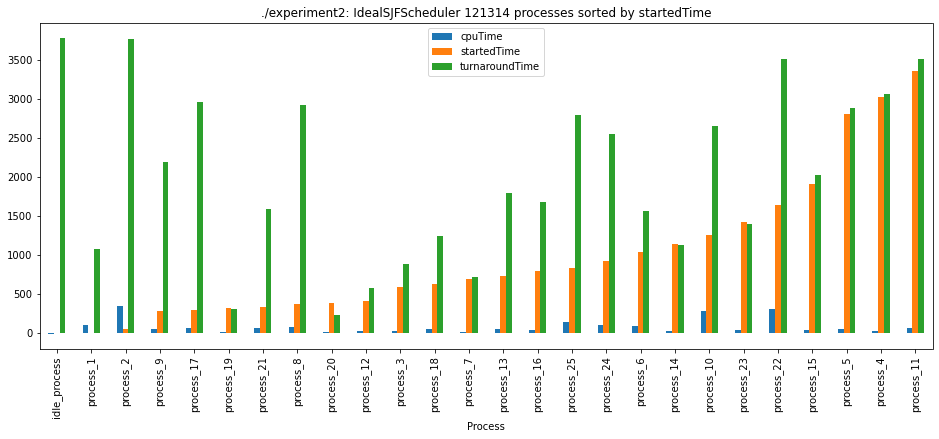

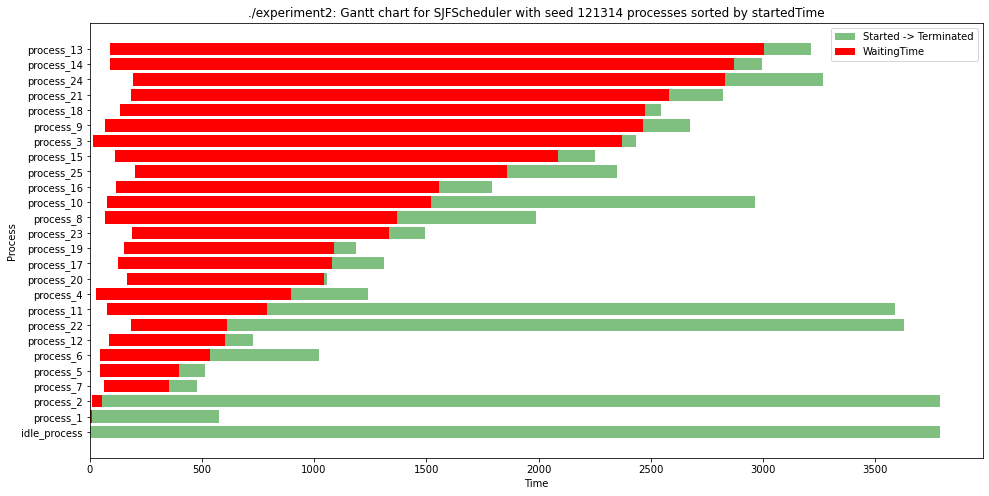

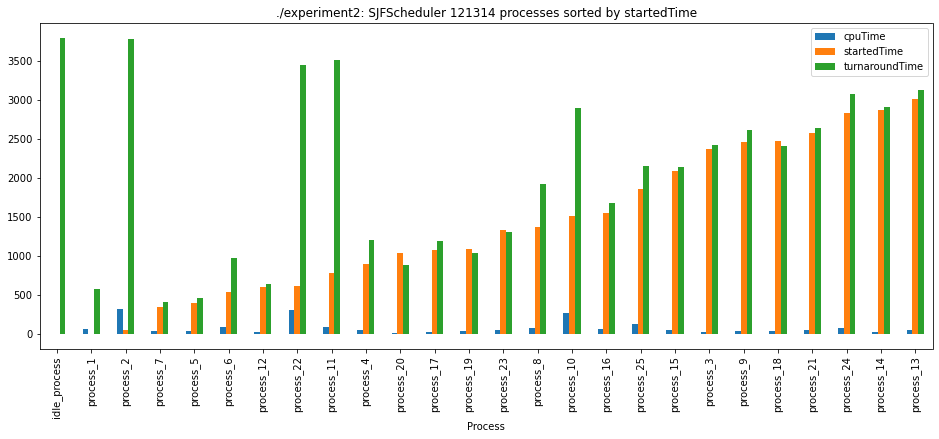

In [12]:
seed_to_analyse = '121314'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 1234

CPU Utilization for FeedbackRRScheduler: 99.929%
CPU Utilization for RRScheduler: 99.003%
CPU Utilization for FcfsScheduler: 98.997%
CPU Utilization for IdealSJFScheduler: 98.997%
CPU Utilization for SJFScheduler: 98.997%


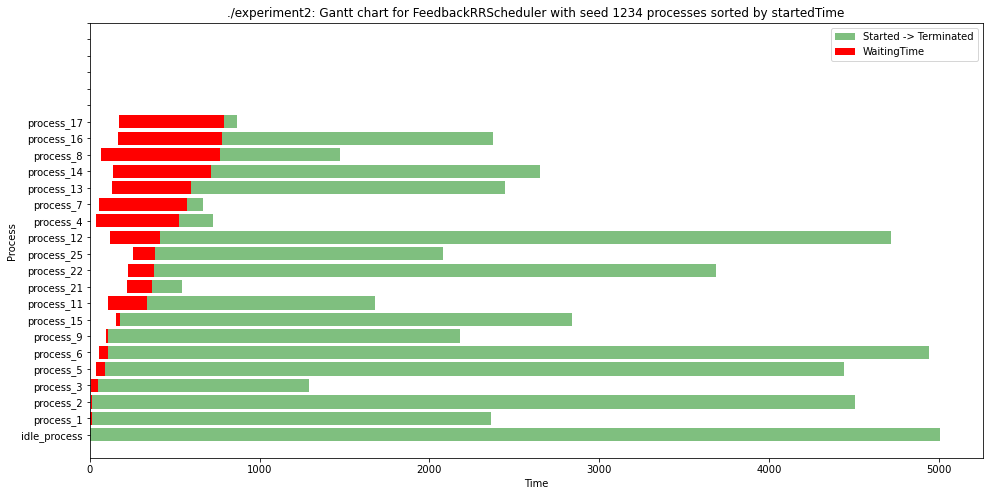

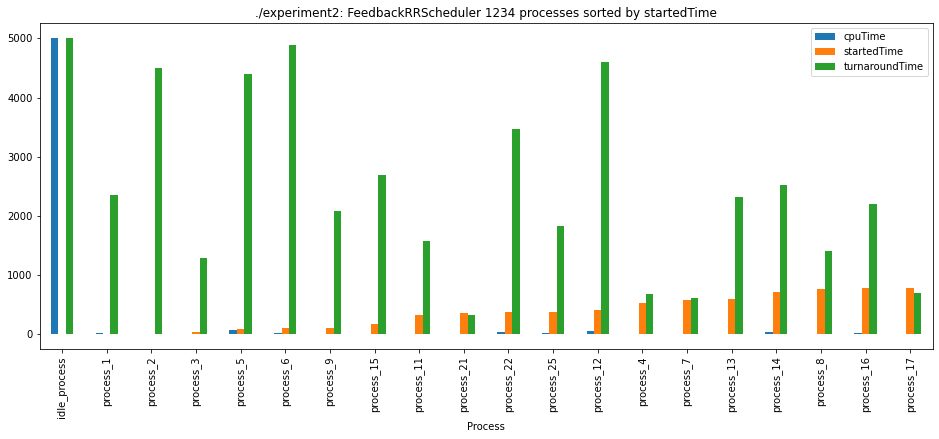

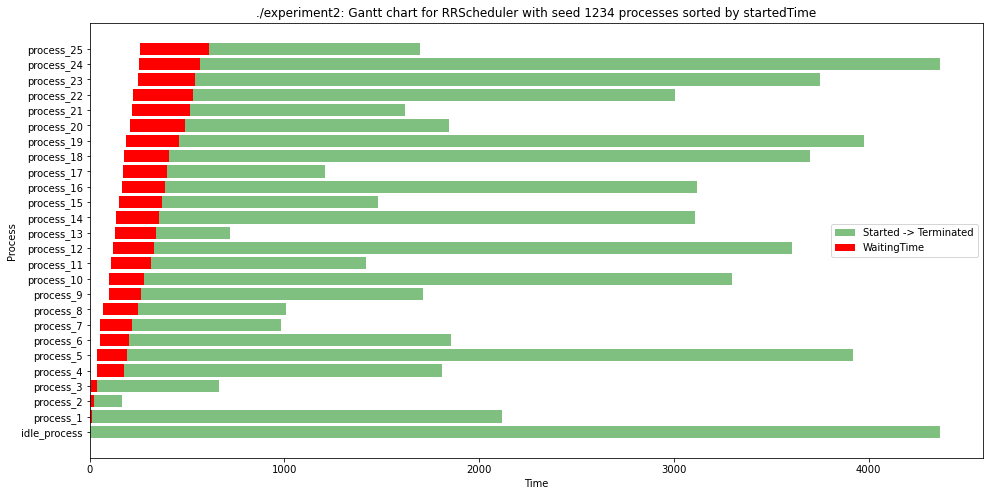

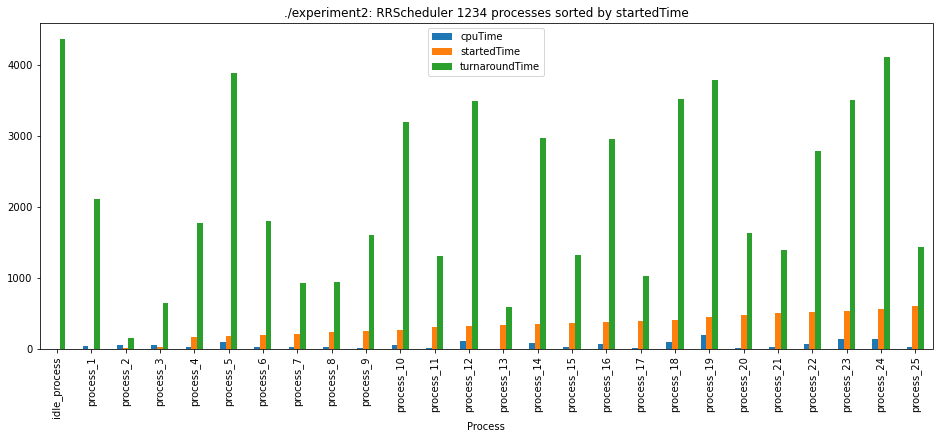

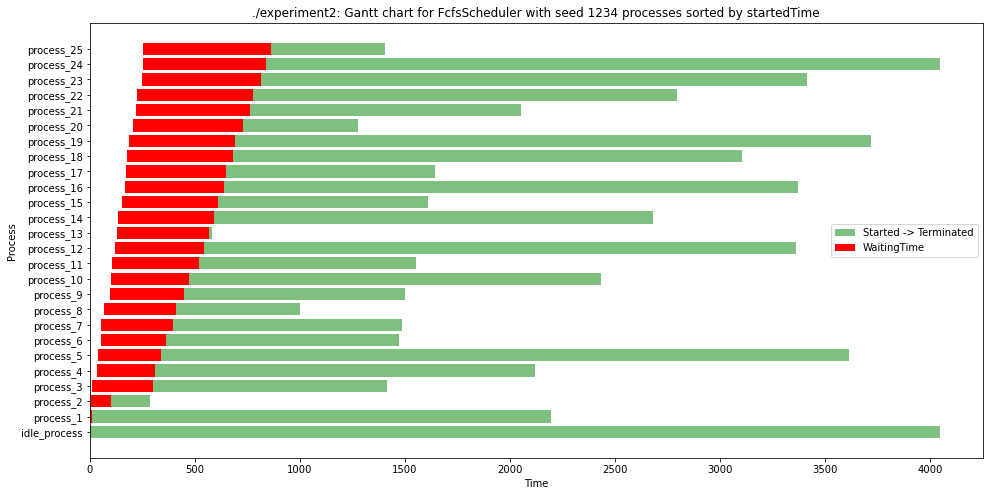

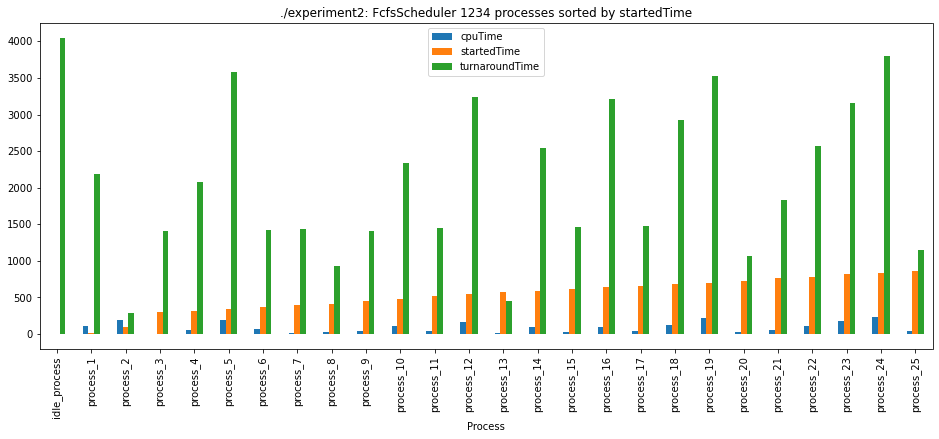

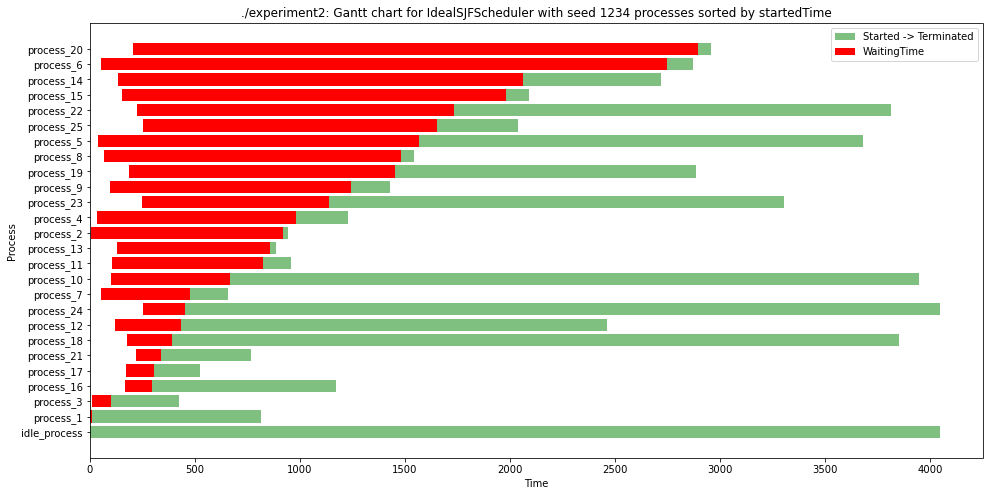

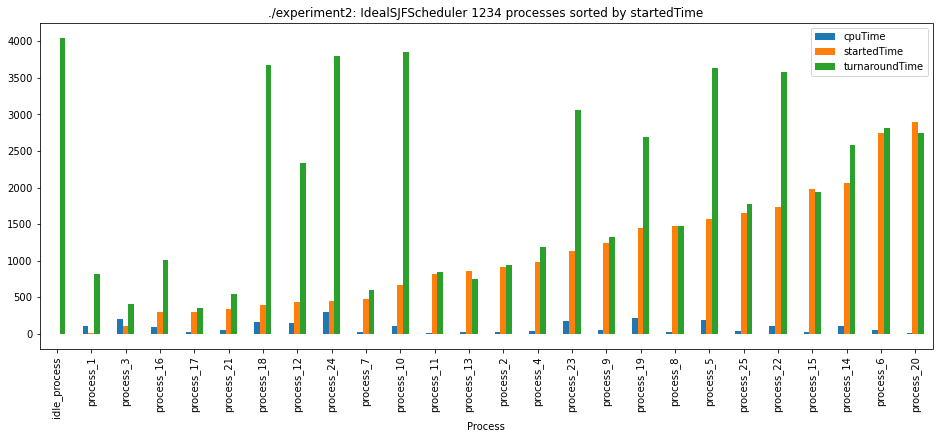

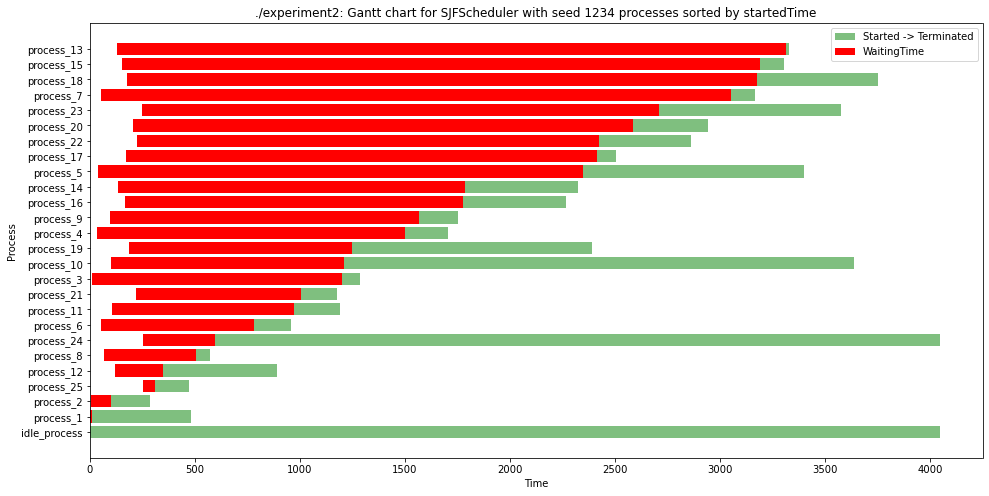

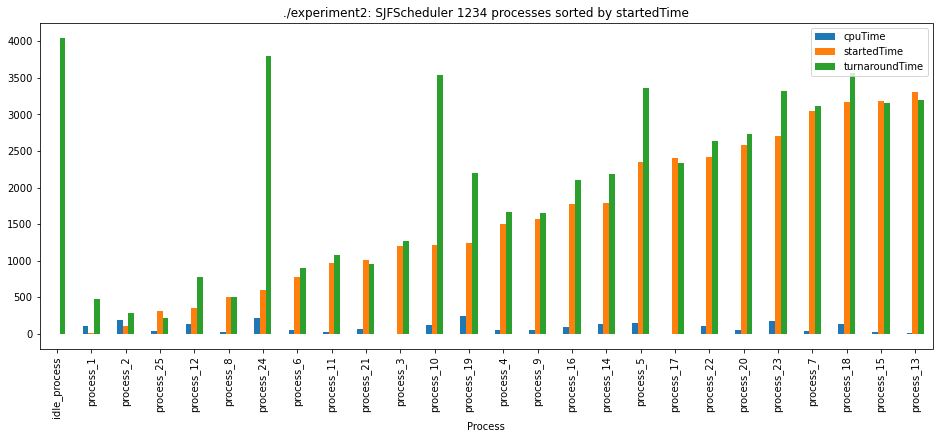

In [13]:
seed_to_analyse = '1234'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)
	

In [14]:
means = results.groupby(['Algorithm']).mean()
means

,MeanWaitingTime,MeanTurnaroundTime,CpuUtilization
Algorithm,,,
FcfsScheduler,383.853846,1569.269231,98.990222
FeedbackRRScheduler,202.940000,2059.794000,99.222625
IdealSJFScheduler,780.130769,1123.630769,98.990813
RRScheduler,291.369231,1796.838462,98.992204
SJFScheduler,1228.492308,636.292308,98.997018


<AxesSubplot:ylabel='Algorithm'>

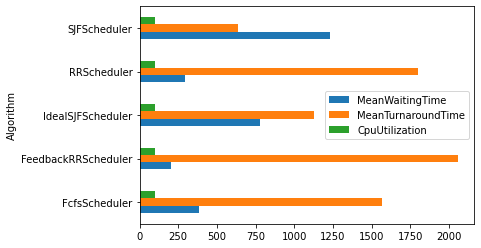

In [15]:
means.plot.barh()

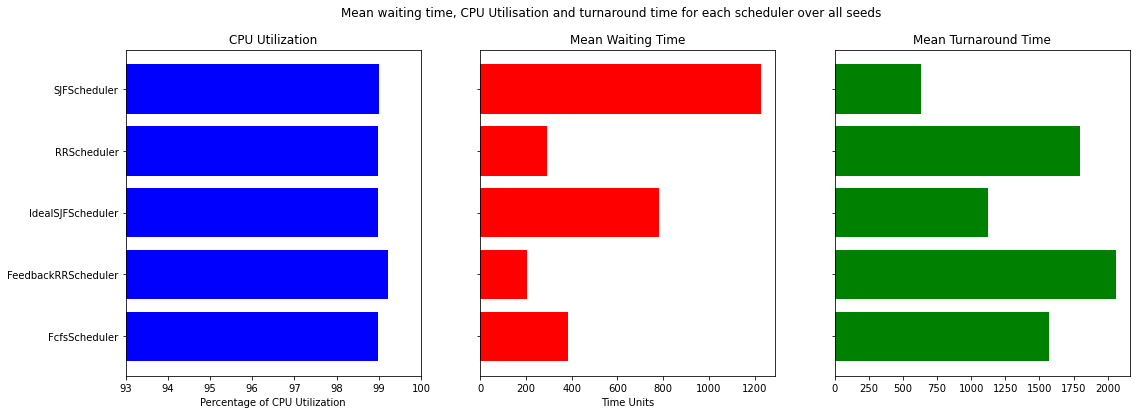

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey='all',)

fig.set_size_inches(18, 6)

fig.suptitle("Mean waiting time, CPU Utilisation and turnaround time for each scheduler over all seeds")

ax1.set_xlabel("Percentage of CPU Utilization")
ax1.barh(means.index, means['CpuUtilization'], color='b')
ax1.set_title("CPU Utilization")
ax1.set_xbound(93, 100)

ax2.set_xlabel("Time Units")
ax2.barh(means.index, means['MeanWaitingTime'], color='r')
ax2.set_title("Mean Waiting Time")

ax3.barh(means.index, means['MeanTurnaroundTime'], color='g')
ax3.set_title("Mean Turnaround Time")
ax2.set_xlabel("Time Units")

plt.show()

The results above outline the Mean CPU Utilization, Mean Waiting Time and Mean Turnaround Time for each scheduling algorithm over all seeds. As we saw in the previous experiment, the Mean Waiting Time for the Feedback Round Robin (FRR) algorithm is the lowest.

### Comparing CPU Utilization

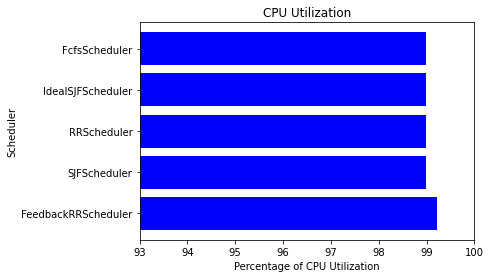

In [21]:
utilisation = pd.DataFrame(means.CpuUtilization).sort_values('CpuUtilization', ascending=False)

plt.barh(utilisation.index, utilisation['CpuUtilization'], color='b')
plt.title("CPU Utilization")
plt.xlabel("Percentage of CPU Utilization")
plt.ylabel("Scheduler")

plt.xlim(93, 100)

plt.show()



Above we can see that CPU Utilization for each of the different algorithms is very similar, with FRR having the highest CPU utilization but only slightly higher than the other algorithms. We can see in better detail below how the CPU Utilization of each of the algorithms compares from the table below.

In [18]:

utilisation

,CpuUtilization
Algorithm,
FeedbackRRScheduler,99.222625
SJFScheduler,98.997018
RRScheduler,98.992204
IdealSJFScheduler,98.990813
FcfsScheduler,98.990222


Looking at the above table, the FRR algorithm has the best average CPU utilization over all the seeds leading by about `0.223%` compared to the Shortest Job First Algorithm. Comparing the utilisation of the other algorithms, we can see that this is by far the largest margin between two consecutive algorithms. With each of the other algorithms only differing by less than `0.01%`. This leads us to the conclusion that the Multilevel Feedback Queue is a substantial improvement over the other algorithms when it comes to maximizing CPU utilization.

### Comparing Average Turnaround Time

Text(0, 0.5, 'Scheduler')

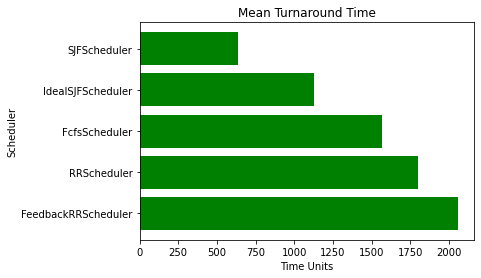

In [20]:
turnaround = pd.DataFrame(means.MeanTurnaroundTime).sort_values('MeanTurnaroundTime', ascending=False)

plt.barh(turnaround.index, turnaround['MeanTurnaroundTime'], color='g')
plt.title("Mean Turnaround Time")
plt.xlabel("Time Units")
plt.ylabel("Scheduler")

plt.show()

The above table shows us that the average turnaround time for Shortest Job First is by far the best. Whilst the Round Robin Scheduler and Feedback Round Robin Scheduler have the worst average turnaround time, this is due to the fact that the Shortest Job First algorithm is using a time quantum to ensure that the processes are forced to context switch even if they have not yet terminated. This means that in Round Robin algorithms, the processes will not be able to run for the entire time quantum, and the processes will have to be forced to context switch. This is why turnaround time is the worst for the Round Robin Scheduler and the Feedback Round Robin Scheduler.

The ordering of the mean turnaround times for Shortest Job First and Ideal Shortest Job First is interesting, since the ideal shortest job first algorithm should perform better than the estimating Shortest Burst Algorithm due to the Ideal algorithm having knowledge about future bursts. However, the reason Ideal Shortest Job First Scheduler performs worse than the Shortest Job First Algorithm is because the Ideal Shortest Job First Algorithm is preemptive and allows for context switches whilst a process is in the middle of a burst, whilst the Shortest Job First Algorithm is non-preemptive and does not allow for context switches while a process is in the middle of a burst, this means Ideal SJFS is more likely to be able to complete a burst before the Shortest SJF completes a burst and therefore has a lower average turnaround time.